In [33]:
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from monai.networks.nets.attentionunet import AttentionUnet
from monai.networks.layers import Norm 
from monai.losses import DiceLoss

from torchvision import transforms
from torch.utils.data import DataLoader, random_split


class AttUNETTransfer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = AttentionUnet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,
            channels=(16, 32, 64, 128, 256), 
            strides=(2, 2, 2, 2),
        )
        self.loss = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)

    def training_step(self, batch, batch_idx):
        vol, seg = batch['vol'], batch['seg']
        out = self.model(vol)
        res_loss = self.loss(out, vol)
        self.log('train loss',  res_loss)
        return res_loss 
     
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

test_model = AttUNETTransfer()
print(test_model.model)

AttentionUnet(
  (model): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
      )
    )
    (1): AttentionLayer(
      (attention): AttentionBlock(
        (W_g): Sequential(
          (0): Convolution(
            (conv): Conv3d(16, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          )
          (1): BatchNorm3d(8, eps=1e-05

In [34]:
checkpoint = './lightning_logs/version_13/checkpoints/epoch=29-step=3060.ckpt'
chk_model = AttUNETTransfer.load_from_checkpoint(checkpoint_path=checkpoint)
model = chk_model.model

print(model)

AttentionUnet(
  (model): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
      )
    )
    (1): AttentionLayer(
      (attention): AttentionBlock(
        (W_g): Sequential(
          (0): Convolution(
            (conv): Conv3d(16, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          )
          (1): BatchNorm3d(8, eps=1e-05

In [35]:
DEVICE = torch.device("cuda:0")

In [36]:
test_dir = "D:/MLDatasets/TCGA-GBM Datasets/Testing"
single_test_dir = "D:/MLDatasets/TCGA-GBM Datasets/Testing/singles"

In [37]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

def prepare_testing(in_dir=None, singles_in_dir=None, imaging_index=0, spatial_size=[128, 128, 144]):
    if in_dir is not None:
        path_test_volumes = sorted(glob(os.path.join(in_dir, f"images_{imaging_index}", "*.nii.gz")))
        path_test_segmentation = sorted(glob(os.path.join(in_dir, "segmentation", "*.nii.gz")))
    elif singles_in_dir is not None:
        path_test_volumes = sorted(glob(os.path.join(singles_in_dir, f"images_{imaging_index}", "*.nii.gz")))
        path_test_segmentation = sorted(glob(os.path.join(singles_in_dir, "segmentation", "*.nii.gz")))

    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=(1.0,1.0,1.0), mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=0, a_max=503,b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),
        ]
    )
    
    test_ds = Dataset(data=test_files, transform=test_transforms)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
    return test_loader

In [38]:
'''CHANGE IMAGING INDEX FOR TYPE OF MRI'''
imaging_index = 0 # Using FLAIR as main
testloader = prepare_testing(in_dir=None, singles_in_dir=single_test_dir, imaging_index=imaging_index)
print(len(testloader))

1


In [39]:
test_data = next(iter(testloader))
test_img, test_seg = test_data['vol'], test_data['seg']

print(test_img.shape)
print(test_seg.shape)

torch.Size([1, 1, 128, 128, 144])
torch.Size([1, 1, 128, 128, 144])


In [40]:
from monai.utils import first
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm 

for i, firstdata in enumerate(iter(testloader)):
    if(i == 0): 
        break

In [41]:
from monai.transforms import(
    Activations,
    AsDiscrete
)
from monai.inferers import sliding_window_inference

def testing_inference(input=None, roi_size=(128, 128, 144), sw_batch_size=1, predictor=None):
    #test_output = sliding_window_inference(input, roi_size=roi_size, sw_batch_size=sw_batch_size, predictor=predictor, overlap=0.5)
    test_output = input > 0.85
    return test_output

Image shape is: torch.Size([1, 1, 128, 128, 144])
Label shape is: torch.Size([1, 1, 128, 128, 144])
Output shape is: torch.Size([1, 1, 128, 128, 144])


  0%|          | 0/4 [00:00<?, ?it/s]

[0 1 2 4]


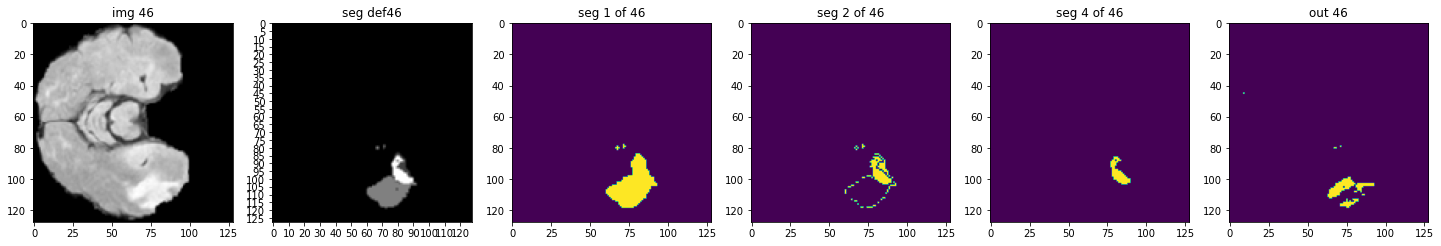

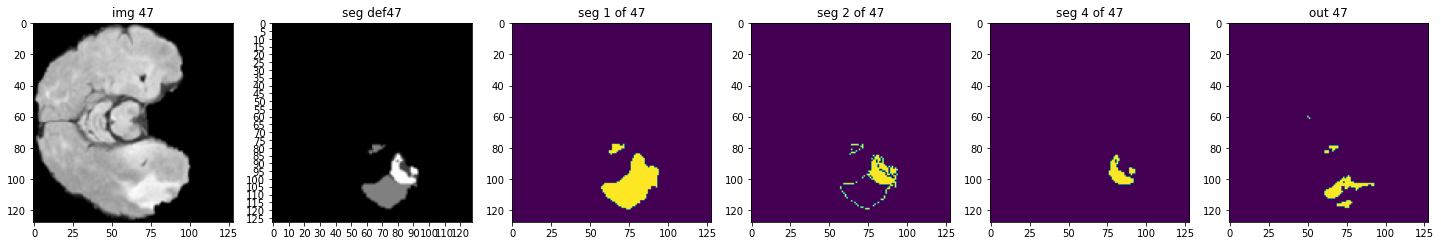

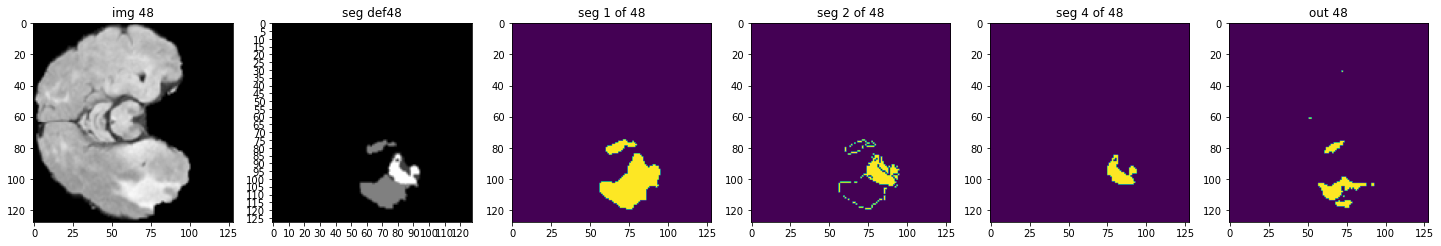

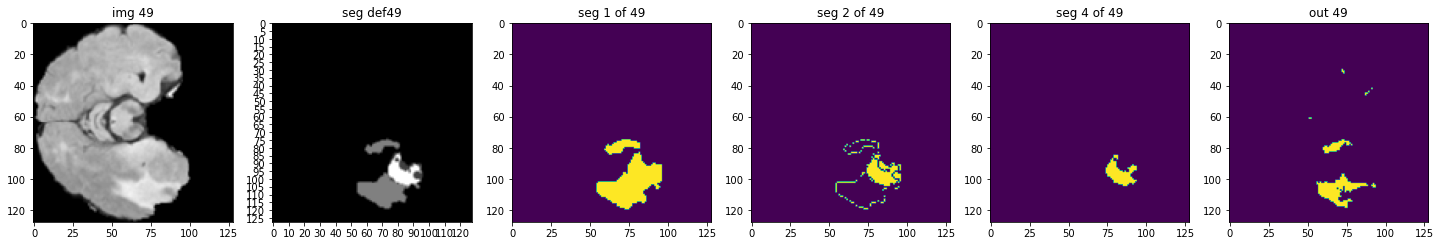

In [42]:
with torch.no_grad():
    model.eval()
    first_volume = firstdata['vol']
    _first_output = model(first_volume) 
    first_output = testing_inference(input=first_volume, predictor=model)
    print(f"Image shape is: {firstdata['vol'].shape}")
    print(f"Label shape is: {firstdata['seg'].shape}")
    print(f"Output shape is: {first_output.shape}")


    for i in tqdm(range(46, 50)):
        
        slide = firstdata['seg'][0, 0, :, :, i].cpu().detach().numpy()
        slide = np.rint(slide).astype(np.uint8)
        slide[slide==3] = 4
        if(i == 46): 
            print(np.unique(slide))
        plt.figure("Training NIFTI", (25, 10))
        plt.subplot(1, 6, 1)
        plt.title(f"img {i}")
        plt.imshow(firstdata['vol'][0, 0, :, :, i], cmap="gray")

        '''Start Printing label'''
        plt.subplot(1, 6, 2)
        plt.yticks(np.arange(0, 129+1, 5))
        plt.xticks(np.arange(0, 129+1, 10))
        plt.title(f"seg def{i}")
        plt.imshow(firstdata['seg'][0, 0, :, :, i], cmap="gray")

        plt.subplot(1, 6, 3)
        plt.title(f"seg 1 of {i}")
        plt.imshow(torch.logical_or(torch.logical_or(torch.from_numpy(slide == 1), torch.from_numpy(slide == 2)), torch.from_numpy(slide == 4)))

        plt.subplot(1, 6, 4)
        plt.title(f"seg 2 of {i}")
        plt.imshow(torch.logical_or(torch.from_numpy(slide == 1), torch.from_numpy(slide == 4)))

        plt.subplot(1, 6, 5)
        plt.title(f"seg 4 of {i}")
        plt.imshow(slide == 4)

        '''End Print Label'''
        plt.subplot(1, 6, 6)
        plt.title(f"out {i}")
        plt.imshow(first_output[0, 0, :, :, i])
        plt.show()